 # Configs and Initializations

## Spark

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master("local[{}]".format(70))
    .config("spark.driver.memory", "{}g".format(20))
    .config("spark.driver.maxResultSize", f"{10}g")
    .getOrCreate()
)


22/10/17 15:39:40 WARN Utils: Your hostname, thurman resolves to a loopback address: 127.0.1.1; using 128.205.43.147 instead (on interface eno1)
22/10/17 15:39:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/17 15:39:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading Dataset

## load pickle data

In [2]:
import pickle


PATH = './bios2020.pkl'
with open(PATH, 'rb') as f:
    bios = pickle.load(f)
    
bios[:3]

['Doer, maker, photo-taker. Words: http://fashionist.contently.com BFF.fm Radio DJ: http://bff.fm/shows/mai-charlie',
 'I like to build things (@Foursquare📱, @StockadeFC ⚽️ @StreetFC, Dodgeball 📟) Husband to @Chelsa, dad to 👧🏼❄️ & 👶🏼🚀. I enjoy snowboards, soccer & hot dogs',
 'Product and Design Leader. Formerly @getfandom, @ign, and @yahoo. I build great teams that build great products.']

In [3]:
print(f"size of dataset: {len(bios)}")

size of dataset: 16240577


## convert it to spark dataframe

In [4]:
import pyspark.sql.functions as F

bios_df = spark.createDataFrame([{'text': x} for x in bios])
#bios_df = bios_df.withColumn("id", F.monotonically_increasing_id())

bios_df.show(5)

22/10/17 14:57:00 WARN TaskSetManager: Stage 0 contains a task of very large size (18843 KiB). The maximum recommended task size is 1000 KiB.


22/10/17 14:57:04 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker
+--------------------+
|                text|
+--------------------+
|Doer, maker, phot...|
|I like to build t...|
|Product and Desig...|
|Founder at @hello...|
|Compassionate Tec...|
+--------------------+
only showing top 5 rows



## store dataset in parquet format for future

In [9]:
PATH = './bios2020.parquet'
bios_df.write.parquet(PATH, mode='overwrite')

22/10/17 14:41:03 WARN TaskSetManager: Stage 6 contains a task of very large size (18843 KiB). The maximum recommended task size is 1000 KiB.


## loading the parquet dataset

In [2]:
PATH = './bios2020.parquet'
bios_df = spark.read.parquet(PATH)

# Data Preprocessing and Cleaning

## data schema

In [3]:
bios_df.show(5)

+-------------------------+------------+
|                     text|          id|
+-------------------------+------------+
|     taga rt and like ...|549755813888|
|           sookai she her|549755813889|
|     В глубине души вс...|549755813890|
|     ★ 1998 ╱ illusory...|549755813891|
|V→🦊⚔️🍚🔺など 絵描き ...|549755813892|
+-------------------------+------------+
only showing top 5 rows



In [4]:
print(f"total rows: {bios_df.count()}")

total rows: 16240577


## cleaning text

In [5]:
def clean_personal_marker(phrase):
    """ Clean a clause extracted from a description"""
    
    if not phrase:
        return None

    # drop weird special characters
    phrase = phrase.encode('ascii', errors='ignore').decode().strip()
    x_prev = phrase

    while True:
        # remove excess whitespace
        phrase = re.sub(r"\s+", " ", phrase).strip()

        # remove personal markers such as I like X
        phrase = re.sub(r"^i (love|like|enjoy) ", "", phrase)
        # remove personal references such as I am a Y
        phrase = re.sub(r"^(i am|i'm|i'm) (a |an )?", "", phrase)
        # remove personal pronouns
        phrase = re.sub(r"^(i |a[n]?)\b", "", phrase)
        # remove unimportant words at the beginning and end of clause
        phrase = re.sub(r"^(and|the|from|to)\b", "", phrase)
        phrase = re.sub(r" of$", "", phrase)
        
        # removes social media links (snapchat, ig, email and phone address) mentions from bio
        phrase = re.sub(r'(on )?(snapchat|snap|ig|insta|instagram|email|phone): +[A-Za-z0-9_@.-]+', " ", phrase)
        
        # remove special characters
        phrase = re.sub(r'\u200d', "", phrase)

        # remove unimportant marks at the beginning and end of each phrase
        phrase = phrase.strip().strip(".,/!-]+[:)(-?'$%&_").strip()
        
        # remove some markers from the whole sentence
        phrase = re.sub(r"[!\(\)?.\{\}]", " ", phrase).strip()
        
        if phrase == x_prev:
            return phrase

        x_prev = phrase



In [6]:
from tqdm import tqdm
import re
import pyspark.sql.functions as F
import pyspark.sql.types as T
import emoji


def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

emojiexp = get_emoji_regexp()

@F.udf(returnType=T.ArrayType(T.StringType()))
def generate_personal_identifiers(description):
    """
    Splits up a profile description into a set of clauses. Returns the clauses and
    all emojis in the description (which are being treated as identity markers)
    """

    # lower cases the text
    # remove email addresses
    d = re.sub(r'\w+@\w+\.\w+', '', description.lower()).strip()
    # remove urls
    d = re.sub(r'http\S+', '', d).strip()
    # replace excess space characters
    d = d.replace("&emsp;", "").replace("&nbsp;", "")

    # get all emoji and treat them as split characters
    d = emojiexp.sub("|", string=d)  # .encode("ascii","namereplace").decode()

    # split on sensible split characters
    # | and
    spl = [x for x in re.split(
        r"[\(\)|•*;~°,\n\t]|[!…]+|[-–\/.]+ | [&+:]+ | [+] |([\/])(?=[A-Za-z ])|([.!-]{2,})| and |([#@][A-Za-z0-9_]+)",
        d.lower()) if (
                   x and x.strip() != "" and not x.strip() in "|•&*#;~°.!…-/–")]

    # clean all clauses
    spl = [clean_personal_marker(x) for x in spl]
    
    # remove weird things and things that become empty
    spl = [x for x in spl if x.strip() != "" and x.encode() != b'\xef\xb8\x8f']
    
    return spl
        


In [7]:
bios_df = bios_df.withColumn('pi', generate_personal_identifiers(F.col('text')))

bios_df.persist()
bios_df.show(5)

22/10/17 14:57:19 WARN TaskSetManager: Stage 1 contains a task of very large size (18843 KiB). The maximum recommended task size is 1000 KiB.


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/home/csgrad/smadani/venvs/general/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/csgrad/smadani/venvs/general/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

KeyboardInterrupt



In [11]:
#remove bios with empty personal identifiers detected
bios_df = bios_df.filter(F.size(F.col('pi')) > 0)
bios_df.select("id", F.col('pi').alias("pis")).write.parquet("pis.parquet")

# EDA

## load data

In [3]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

pis_df = spark.read.parquet('pis.parquet')
pis_df.persist()

pis_df.show(5)
n_distinct_bios = pis_df.count()

+-----------+--------------------+
|         id|                 pis|
+-----------+--------------------+
|42949672960|[harold edward st...|
|42949672961|[tony, underrated...|
|42949672962|[no sides, just g...|
|42949672963|[fan account, o, ...|
|42949672964|[lder del club ni...|
+-----------+--------------------+
only showing top 5 rows



In [45]:
n_distinct_bios

15033198

## distribution of number of pis each user have

Text(0.5, 1.0, 'distribution of number of PIs in a bio')

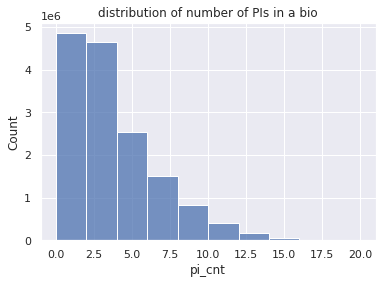

In [36]:

pi_cnt_df = (
    pis_df
    .withColumn('pi_cnt', F.size(F.col('pis')))
    .select('id', 'pi_cnt')
    .toPandas()
)

sns.histplot(pi_cnt_df['pi_cnt'], log_scale=False, bins=[0,2,4,6,8,10,12,14,16,18,20])
plt.title("distribution of number of PIs in a bio")


In [37]:
np.mean(pi_cnt_df['pi_cnt']), np.median(pi_cnt_df['pi_cnt'])

(3.4150380378147083, 2.0)

## extract qunatifying stats

In [31]:
import pyspark.sql.functions as F


pi_df = pis_df.select("id", F.explode("pis").alias("pi"))

# remove single character PIs
pi_df = pi_df.filter(F.length(F.col('pi'))>1)

pi_df.persist()
pi_df.show(5)

# counting distinct bios
n_distinct_pis = pi_df.select("pi").distinct().count()

# calculating frequency of each pi
pi_cnt_pdf = pi_df.groupBy("pi").agg(F.count(F.lit(1)).alias('cnt')).toPandas()
counts = pi_cnt_pdf['cnt']


+-----------+--------------------+
|         id|                  pi|
+-----------+--------------------+
|42949672960|harold edward sty...|
|42949672961|                tony|
|42949672961|underrated contro...|
|42949672961|             manager|
|42949672961|               dm me|
+-----------+--------------------+
only showing top 5 rows



In [46]:
n_distinct_pis

19784548

## hashtag pis

In [38]:
import pyspark.sql.types as T

hashtags_df = pi_df.filter(pi_df.pi.rlike('#[a-zA-Z0-9(_)]+')).withColumnRenamed('pi', 'hashtag')
hashtags_df.show(10)

+-----------+---------------+
|         id|        hashtag|
+-----------+---------------+
|42949672964|          #gor7|
|42949672964|         #goest|
|42949672964|         #t1win|
|42949672964|        #flywin|
|42949672975|     #gregghead|
|42949672977|    #calicarter|
|42949672977|  #abelladanger|
|42949672977|     #meganrain|
|42949672977|#adrianachechik|
|42949672987|    #fitstyczen|
+-----------+---------------+
only showing top 10 rows



In [39]:
# extract distinct hashtags
n_distinct_hashtags = hashtags_df.select('hashtag').distinct().count()
n_distinct_hashtags

847260

In [40]:
# extract ratio of users that use hashtags in their bios

users_with_hashtags = hashtags_df.select("id").distinct()
print(users_with_hashtags.count())


1979278


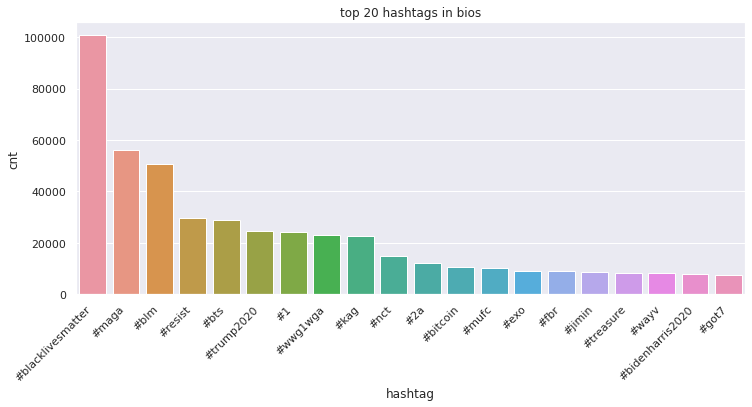

In [43]:
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt

def plot_top_k(df, col, title, k=10):
    grouped_df = (
        df
        .groupBy(col)
        .agg(F.count(F.lit(1)).alias('cnt'))
        .orderBy(F.col('cnt').desc())
        .limit(k)
    ).toPandas()
    
    plt.figure(figsize=(12, 5))
    sns.barplot(data=grouped_df, x=col, y='cnt')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_top_k(hashtags_df, 'hashtag', title='top 20 hashtags in bios', k=20)

## PI frequency stats

In [5]:
import numpy as np
import seaborn as sns


# extract mean and median of pi 
mean_pi_cnt, median_pi_cnt = np.mean(list(counts)), np.median(list(counts))
mean_pi_cnt, median_pi_cnt

(2.5948929796894142, 1.0)

Text(0.5, 1.0, 'distribution of frequency of each PI')

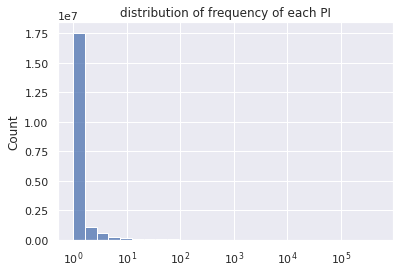

In [47]:
sns.histplot(list(counts), log_scale=True)
plt.title("distribution of frequency of each PI")

## keeping meaningful PIs

based on the above count distribution of PIs, since most of the PIs are unique and never occured, they are not 
informative for this task, so I try to clean data and only keep most informative PIs by removing PIs that repeat
less than 10 times in the dataset

In [50]:
pi_cnt_df = (
    pi_df
    .groupBy("pi").agg(F.count(F.lit(1)).alias('cnt'))
    .filter(F.col('cnt') > 10)
)

pi_cnt_pdf = pi_cnt_df.toPandas()
counts = list(pi_cnt_pdf['cnt'])

In [51]:
filtered_pi_df = pi_df.join(pi_cnt_df, how='right', on='pi')
filtered_pi_df.show(5)

+-----+-----------+-----+
|   pi|         id|  cnt|
+-----+-----------+-----+
|anime|42949673480|31405|
|anime|42949674506|31405|
|anime|42949675356|31405|
|anime|42949676196|31405|
|anime|42949676306|31405|
+-----+-----------+-----+
only showing top 5 rows



In [53]:
print(f'distinct users after filtering: {filtered_pi_df.select("id").distinct().count()}')
print(f'distinct pis after filtering: {filtered_pi_df.select("pi").distinct().count()}')

ht_cnt = filtered_pi_df.filter(pi_df.pi.rlike('#[a-zA-Z0-9(_)]+'))\
.withColumnRenamed('pi', 'hashtag').select("hashtag").distinct().count()

print(f'distinct hashtags after filtering: {ht_cnt}')

distinct users after filtering: 10242965


distinct pis after filtering: 266679


distinct hashtags after filtering: 32412


In [54]:
# extract mean and median of pi 
mean_pi_cnt, median_pi_cnt = np.mean(counts), np.median(counts)
mean_pi_cnt, median_pi_cnt

(100.10152655439686, 22.0)

<AxesSubplot:ylabel='Count'>

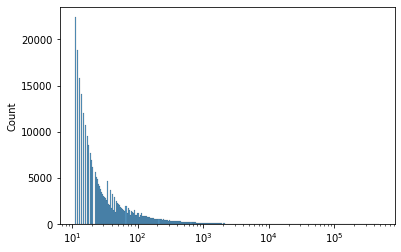

In [9]:
sns.histplot(list(counts), log_scale=True)

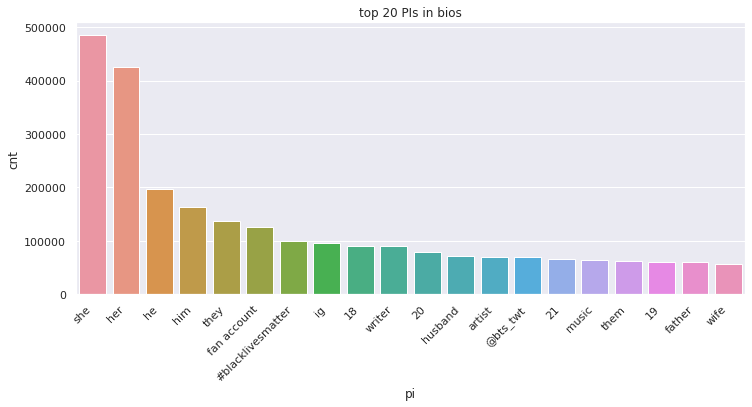

In [44]:
plot_top_k(pi_df, col='pi', k=20, title='top 20 PIs in bios')

## pie chart of democrats and republicans based on keywords

In [64]:

dem_kw = [
    'biden supporter', 'bidenharris', 'bidenharris2020', 'biden2020', 
    'democrat', 
]

repub_kw = [
    'republican', 'trump supporter', 'trump2020', 'maga',
     'conservative'
]

repubs = pi_df.filter(pi_df.pi.rlike('|'.join(repub_kw))).select('id').distinct()
dems = pi_df.filter(pi_df.pi.rlike('|'.join(dem_kw))).select('id').distinct()

others = (
    pi_df
    .select('id').distinct()
    .join(repubs, how='left_anti')
    .join(dems, how='left_anti')
    .select('id')
)

data = [repubs.count(), dems.count()]
labels = ['republican', 'democrat']



In [63]:
repubs.count(), dems.count(), pi_df.select('id').distinct().count()

(174788, 47702, 14908979)

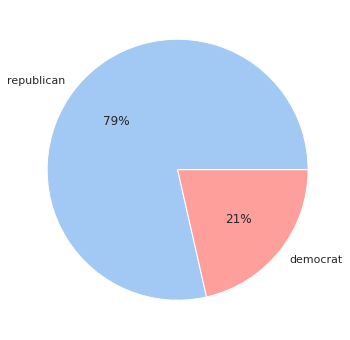

In [66]:
colors = sns.color_palette('pastel')[0:5]
colors = [colors[0], colors[3],]

plt.figure(figsize=(6,6))
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

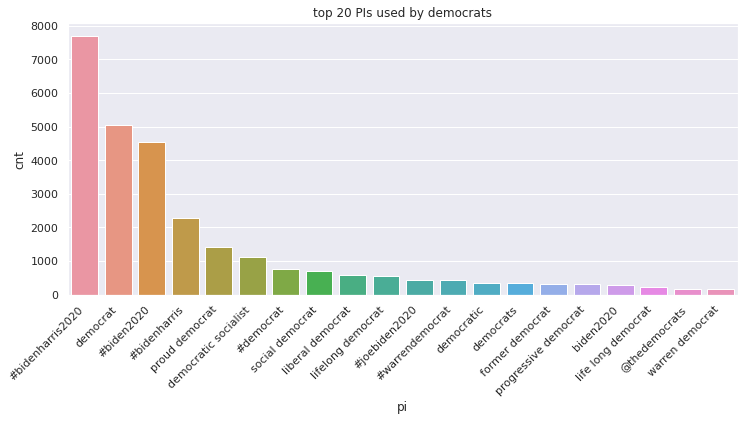

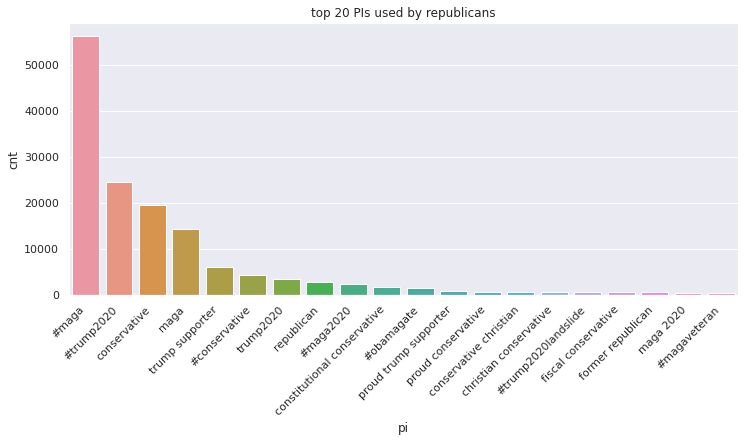

In [67]:
repubs = pi_df.filter(pi_df.pi.rlike('|'.join(repub_kw)))
dems = pi_df.filter(pi_df.pi.rlike('|'.join(dem_kw)))

plot_top_k(dems, col='pi', k=20, title='top 20 PIs used by democrats')
plot_top_k(repubs, col='pi', k=20, title='top 20 PIs used by republicans')